In [1]:
import os
import kagglehub

# Download latest version
path = kagglehub.dataset_download("feyzazkefe/trashnet")

print("Path to dataset files:", path)
dataset_path = os.path.join(path, 'dataset-resized')

100%|██████████| 40.8M/40.8M [00:00<00:00, 92.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/feyzazkefe/trashnet/versions/1


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# ImageDataGenerator for clean images
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_gen = datagen.flow_from_directory(
    dataset_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='input',   # key: autoencoder input = output
    subset='training',
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    dataset_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='input',
    subset='validation',
    shuffle=False
)


Found 2024 images belonging to 6 classes.
Found 503 images belonging to 6 classes.


In [4]:
def add_noise(images):
    noise = np.random.normal(0, 0.1, images.shape)  # Gaussian noise
    return np.clip(images + noise, 0., 1.)

class NoisyGenerator(tf.keras.utils.Sequence):
    def __init__(self, base_generator):
        self.base_generator = base_generator

    def __len__(self):
        return len(self.base_generator)

    def __getitem__(self, idx):
        clean_batch, _ = self.base_generator[idx]   # ignore labels
        noisy_batch = add_noise(clean_batch)
        return noisy_batch, clean_batch

train_noisy = NoisyGenerator(train_gen)
val_noisy = NoisyGenerator(val_gen)


In [5]:
def build_autoencoder(input_shape=(224,224,3)):
    input_img = layers.Input(shape=input_shape)

    # Encoder
    x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(input_img)
    x = layers.MaxPooling2D((2,2), padding='same')(x)
    x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2), padding='same')(x)
    x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
    encoded = layers.MaxPooling2D((2,2), padding='same')(x)

    # Decoder
    x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(encoded)
    x = layers.UpSampling2D((2,2))(x)
    x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2,2))(x)
    x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2,2))(x)
    decoded = layers.Conv2D(3, (3,3), activation='sigmoid', padding='same')(x)

    autoencoder = models.Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder

autoencoder = build_autoencoder()
autoencoder.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 112, 112, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 224, 224, 3)    │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 333,955 (1.27 MB)

 Trainable params: 333,955 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
history = autoencoder.fit(
    train_noisy,
    validation_data=val_noisy,
    epochs=5,
    verbose=1
)


Epoch 1/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 563s 9s/step - loss: 0.0035 - val_loss: 0.0034
Epoch 2/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 558s 9s/step - loss: 0.0035 - val_loss: 0.0032
Epoch 3/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 559s 9s/step - loss: 0.0034 - val_loss: 0.0031
Epoch 4/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 558s 9s/step - loss: 0.0036 - val_loss: 0.0030
Epoch 5/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 568s 9s/step - loss: 0.0032 - val_loss: 0.0030


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step


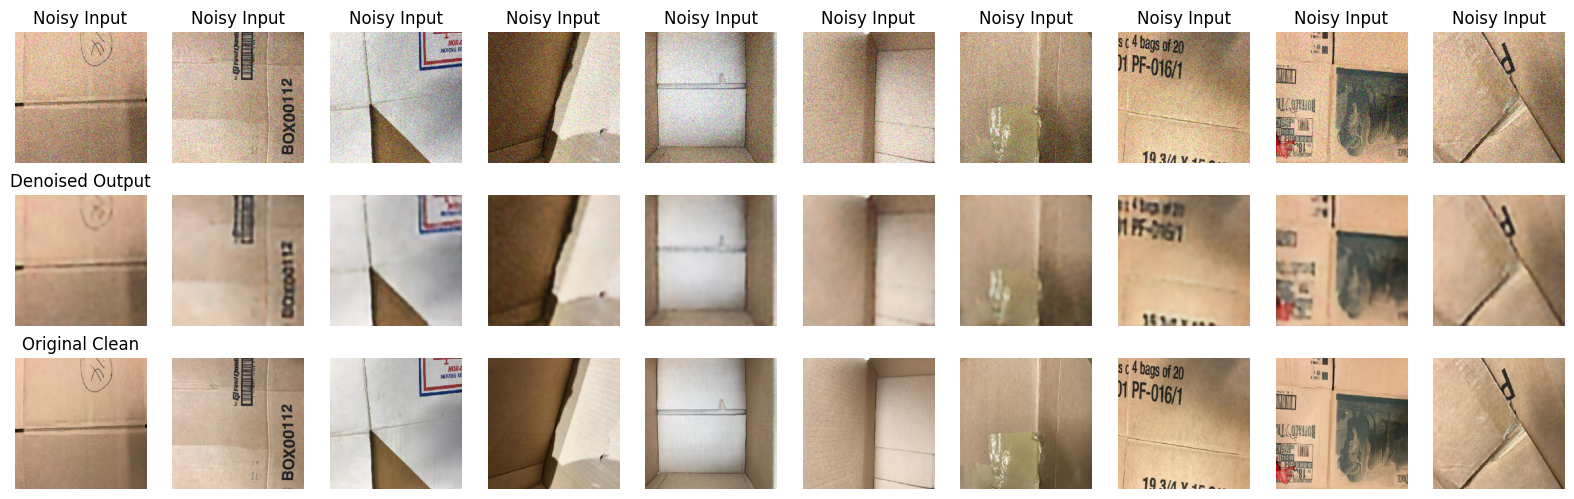

In [12]:
noisy_imgs, clean_imgs = val_noisy[0]
decoded_imgs = autoencoder.predict(noisy_imgs[:10])

n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
    # noisy input
    ax = plt.subplot(3, n, i+1)
    plt.imshow(noisy_imgs[i])
    ax.axis('off')
    ax.set_title("Noisy Input")

    # denoised output
    ax = plt.subplot(3, n, i+1+n)
    plt.imshow(decoded_imgs[i])
    ax.axis('off')
    if i == 0:
        ax.set_title("Denoised Output")


    # original clean
    ax = plt.subplot(3, n, i+1+2*n)
    plt.imshow(clean_imgs[i])
    ax.axis('off')
    if i == 0:
        ax.set_title("Original Clean")

plt.show()